## Deep Learning - Lab 07

* Full name: Đinh Anh Huy
* Student ID: 18110103

### Bài tập 1.
**Dựa vào mô hình GAN ở trên hãy tạo ra một mô hình DCGAN và train trên tập MNIST.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Convolution2D, LeakyReLU, Flatten, Dense, Activation, BatchNormalization, Conv2DTranspose, Reshape, Input

In [2]:
def dc_discriminator(input_shape=(28,28,1)):
  '''
    Define the discriminator model for DCGAN.
  '''
  model = Sequential()

  model.add(Convolution2D(filters=64,
                          kernel_size=[5,5],
                          strides=[2,2],
                          padding='same',
                          input_shape=input_shape))
  model.add(LeakyReLU(0.2))

  model.add(Convolution2D(filters=128,
                          kernel_size=[5,5],
                          strides=[2,2],
                          padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Flatten())

  model.add(Dense(units=1))

  model.add(Activation(activation='sigmoid', name='sigmoid'))
  return model

def dc_generator(latent_dim):
  '''
    Define the generator model for DCGAN.
  '''
  model = Sequential()

  n_nodes = 256 * 7 * 7

  model.add(Input(shape=(100,)))

  model.add(Dense(units=n_nodes,
                  use_bias=False))
  
  model.add(Reshape((7,7,256)))

  model.add(BatchNormalization())

  model.add(Conv2DTranspose(filters=128,
                            kernel_size=(5,5),
                            strides=(1,1),
                            padding='same',
                            use_bias=False))
  
  model.add(BatchNormalization())

  model.add(LeakyReLU(0.2))

  model.add(Conv2DTranspose(filters=64,
                            kernel_size=(5,5),
                            strides=(2,2),
                            padding='same',
                            use_bias=False))
  
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2DTranspose(filters=1,
                            kernel_size=(5,5),
                            strides=(2,2),
                            padding='same',
                            use_bias=False,
                            activation='tanh'))
  
  model.add(Reshape((28,28,1)))
  return model

In [3]:
class DCGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(DCGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
  
  def compile(self, d_optimizer, g_optimizer, loss_function):
    super(DCGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_function = loss_function
  
  def train_step(self, real_images):
    # define batch size from input
    batch_size = tf.shape(real_images)[0]

    # create noises followed the normal distribution
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    # generate fake images from generator network
    generated_images = self.generator(random_latent_vectors)
    # combine fake images and real images into dataset for discriminator model
    combined_images = tf.concat([generated_images, real_images], axis=0)
    # labeling (0 for fake image and 1 for real images)
    labels = tf.concat(
        [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
    )
    # trick: add noise to labels
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
    # Training discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_function(labels, predictions)
      gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
      
    # update weights for discriminator model
    self.d_optimizer.apply_gradients(
        zip(gradients, self.discriminator.trainable_weights)
    )
    
    # create one more noise
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    # create a set of labels that are all 1 to trick discriminator
    misleading_labels = tf.ones((batch_size, 1))
    # Training generator (note that donot update weights for discriminator)
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_function(misleading_labels, predictions)
      gradients = tape.gradient(g_loss, self.generator.trainable_weights)

    # update weights for generator model
    self.g_optimizer.apply_gradients(
        zip(gradients, self.generator.trainable_weights)
    )
    return {'d_loss': d_loss, 'g_loss': g_loss}

In [4]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=100):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images = generated_images * 127.5 + 127.5
    generated_images.numpy()
    print('epoch ', epoch)
    for i in range(self.num_img):
      img = keras.preprocessing.image.array_to_img(generated_images[i])
      display(img)

In [5]:
# create a line plot of loss for the gan and save to file
def plot_history(model_history, marker=None, figsize=(15,8)):
  plt.style.use("ggplot")
  plt.figure(figsize=figsize)

  plt.plot(model_history.history['d_loss'], marker=marker, label='Discriminator Loss')
  plt.plot(model_history.history['g_loss'], marker=marker, label='Generator Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss curve of Discriminator and Generator of DCGAN')
  plt.legend()

In [6]:
buffer_size = 1024
batch_size = 128
latent_dim = 100

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

all_digits = np.concatenate([X_train, X_test])
all_digits = (all_digits.astype('float32') - 127.5) / 127.5
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=buffer_size).batch(batch_size).prefetch(32)

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
discriminator = dc_discriminator(input_shape=(28,28,1))
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
 sigmoid (Activation)        (None, 1)                 0

In [9]:
generator = dc_generator(latent_dim=latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                      

In [10]:
epochs = 250
lr = 2e-4
decay = lr/epochs
beta_1 = 0.5

In [11]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, decay=decay)

dcgan.compile(
    d_optimizer=optimizer,
    g_optimizer=optimizer,
    loss_function=keras.losses.BinaryCrossentropy()
)

history = dcgan.fit(
    dataset,
    epochs=epochs,
    verbose=0,
    callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

epoch  0


epoch  1


epoch  2


epoch  3


epoch  4


epoch  5


epoch  6


epoch  7


epoch  8


epoch  9


epoch  10


epoch  11


epoch  12


epoch  13


epoch  14


epoch  15


epoch  16


epoch  17


epoch  18


epoch  19


epoch  20


epoch  21


epoch  22


epoch  23


epoch  24


epoch  25


epoch  26


epoch  27


epoch  28


epoch  29


epoch  30


epoch  31


epoch  32


epoch  33


epoch  34


epoch  35


epoch  36


epoch  37


epoch  38


epoch  39


epoch  40


epoch  41


epoch  42


epoch  43


epoch  44


epoch  45


epoch  46


epoch  47


epoch  48


epoch  49


epoch  50


epoch  51


epoch  52


epoch  53


epoch  54


epoch  55


epoch  56


epoch  57


epoch  58


epoch  59


epoch  60


epoch  61


epoch  62


epoch  63


epoch  64


epoch  65


epoch  66


epoch  67


epoch  68


epoch  69


epoch  70


epoch  71


epoch  72


epoch  73


epoch  74


epoch  75


epoch  76


epoch  77


epoch  78


epoch  79


epoch  80


epoch  81


epoch  82


epoch  83


epoch  84


epoch  85


epoch  86


epoch  87


epoch  88


epoch  89


epoch  90


epoch  91


epoch  92


epoch  93


epoch  94


epoch  95


epoch  96


epoch  97


epoch  98


epoch  99


epoch  100


epoch  101


epoch  102


epoch  103


epoch  104


epoch  105


epoch  106


epoch  107


epoch  108


epoch  109


epoch  110


epoch  111


epoch  112


epoch  113


epoch  114


epoch  115


epoch  116


epoch  117


epoch  118


epoch  119


epoch  120


epoch  121


epoch  122


epoch  123


epoch  124


epoch  125


epoch  126


epoch  127


epoch  128


epoch  129


epoch  130


epoch  131


epoch  132


epoch  133


epoch  134


epoch  135


epoch  136


epoch  137


epoch  138


epoch  139


epoch  140


epoch  141


epoch  142


epoch  143


epoch  144


epoch  145


epoch  146


epoch  147


epoch  148


epoch  149


epoch  150


epoch  151


epoch  152


epoch  153


epoch  154


epoch  155


epoch  156


epoch  157


epoch  158


epoch  159


epoch  160


epoch  161


epoch  162


epoch  163


epoch  164


epoch  165


epoch  166


epoch  167


epoch  168


epoch  169


epoch  170


epoch  171


epoch  172


epoch  173


epoch  174


epoch  175


epoch  176


epoch  177


epoch  178


epoch  179


epoch  180


epoch  181


epoch  182


epoch  183


epoch  184


epoch  185


epoch  186


epoch  187


epoch  188


epoch  189


epoch  190


epoch  191


epoch  192


epoch  193


epoch  194


epoch  195


epoch  196


epoch  197


epoch  198


epoch  199


epoch  200


epoch  201


epoch  202


epoch  203


epoch  204


epoch  205


epoch  206


epoch  207


epoch  208


epoch  209


epoch  210


epoch  211


epoch  212


epoch  213


epoch  214


epoch  215


epoch  216


epoch  217


epoch  218


epoch  219


epoch  220


epoch  221


epoch  222


epoch  223


epoch  224


epoch  225


epoch  226


epoch  227


epoch  228


epoch  229


epoch  230


epoch  231


epoch  232


epoch  233


epoch  234


epoch  235


epoch  236


epoch  237


epoch  238


epoch  239


epoch  240


epoch  241


epoch  242


epoch  243


epoch  244


epoch  245


epoch  246


epoch  247


epoch  248


epoch  249


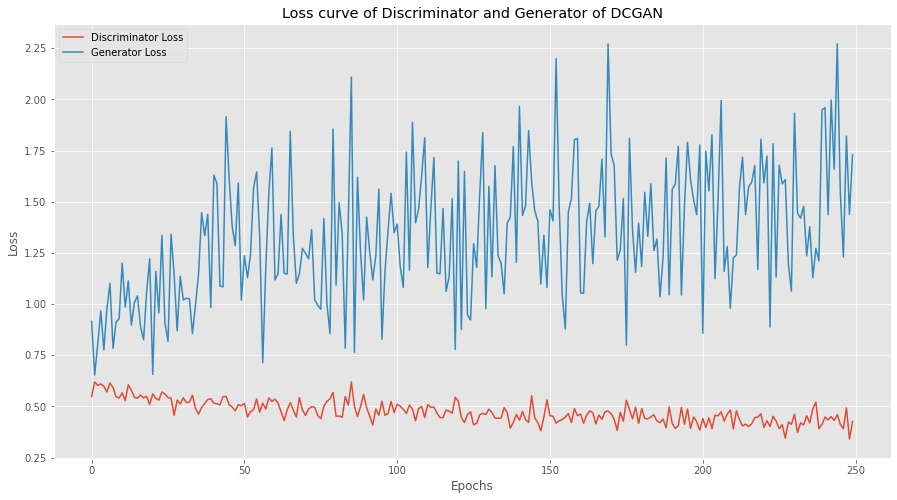

In [12]:
plot_history(history)

### Bài tập 2.
**Sau khí train xong, hãy viết một hàm sao cho khi đưa vào 4 latent random vectors thì mô hình sẽ tạo ra 4 samples.**

In [13]:
def generate_samples(model, num_latent_vectors, latent_dim=100, figsize=(15,8)):
  random_latent_vectors = tf.random.normal(shape=(num_latent_vectors, latent_dim))
  generated_images = model.generator(random_latent_vectors)
  generated_images = generated_images * 127.5 + 127.5
  generated_images.numpy()

  plt.style.use("default")
  fig, axs = plt.subplots(1, num_latent_vectors, figsize=figsize)
  for i in range(num_latent_vectors):
    image = keras.preprocessing.image.array_to_img(generated_images[i])
    axs[i].imshow(image)

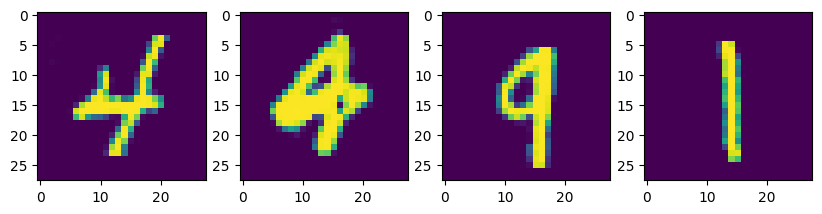

In [14]:
generate_samples(dcgan, 4, figsize=(10,3))